In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType,StructField,StringType, DateType,IntegerType
from pyspark import SparkFiles

In [2]:
import pandas as pd

companies = ['AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'EKPC', 'FE', 'NI', 'PJME', 'PJMW']

# dictionary comprehension of all companies
dfs = {company: pd.read_csv(f"Resources/PJM/{company}_hourly.csv").set_index('Datetime') for company in companies}

# showing example
dfs['FE']

,FE_MW
Datetime,
2011-12-31 01:00:00,6222.0
2011-12-31 02:00:00,5973.0
2011-12-31 03:00:00,5778.0
2011-12-31 04:00:00,5707.0
2011-12-31 05:00:00,5691.0
...,...
2018-01-01 20:00:00,9378.0
2018-01-01 21:00:00,9255.0
2018-01-01 22:00:00,9044.0


In [3]:
# checking to see the dtypes
dfs['FE'].dtypes

FE_MW    float64
dtype: object

In [4]:
# making data into data
for company in companies:
    dfs[company].index = pd.to_datetime(dfs[company].index)

dfs['FE'].index

DatetimeIndex(['2011-12-31 01:00:00', '2011-12-31 02:00:00',
               '2011-12-31 03:00:00', '2011-12-31 04:00:00',
               '2011-12-31 05:00:00', '2011-12-31 06:00:00',
               '2011-12-31 07:00:00', '2011-12-31 08:00:00',
               '2011-12-31 09:00:00', '2011-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=62874, freq=None)

In [10]:
# making plots for all the data
import hvplot.pandas

dfs_plots = {company: dfs[company].hvplot.line(
                                    title = f"{company}'s energy production over time",
                                    ) for company in companies
                                    }

dfs_plots['FE']

:Curve   [Datetime]   (FE_MW)

In [8]:
# making datetime into days
resampled = {company: dfs[company].resample('D').sum() for company in companies}
resampled['FE']

,FE_MW
Datetime,
2011-06-01,208083.0
2011-06-02,185818.0
2011-06-03,176788.0
2011-06-04,180699.0
2011-06-05,188311.0
...,...
2018-07-30,193863.0
2018-07-31,195607.0
2018-08-01,196392.0


In [11]:
# making plots for resampled data
resampled_plots = {company: resampled[company].hvplot.line(
                                    title = f"{company}'s energy production over time",
                                    ) for company in companies
                                    }

resampled_plots['FE']

:Curve   [Datetime]   (FE_MW)

In [47]:
# curve fitting to get our line
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# have to make our function for sinusoidal regression
def sine(x, a, b, c, d):
    return a * np.sin(b * (x - c)) + d

# make dict
plot_data = {}

for company in companies:

    # make data into time stamps
    timestamp = [time.timestamp() for time in resampled[company].index]

    # gets values need for regression
    popt, cov = curve_fit(sine, timestamp, resampled[company][f'{company}_MW'])
    print(popt)
    # store variables for future
    plot_data[company] = sine(timestamp, *popt)

plot_data['FE']

[9.74503271e+02 9.99988879e-01 1.00000000e+00 3.71851990e+05]
[-3.80114942e+02  9.99988474e-01  1.00000000e+00  2.73955903e+05]
[2.73285420e+01 9.99997880e-01 1.00000000e+00 4.88907934e+04]
[7.15280431e+02 1.00000520e+00 1.00000000e+00 7.44861990e+04]
[-5.04213413e+02  1.00000059e+00  1.00000000e+00  2.62710733e+05]
[1.22340677e+02 1.00000019e+00 1.00000000e+00 3.97969399e+04]
[1.23842239e+02 1.00000522e+00 1.00000000e+00 3.51211617e+04]
[-4.93731420e+01  9.99990695e-01  1.00000000e+00  1.86922638e+05]
[-3.73013889e+02  9.99974620e-01  1.00000000e+00  2.80657916e+05]
[7.80781367e+01 9.99994533e-01 1.00000000e+00 7.69661992e+05]
[9.08947972e+01 9.99999403e-01 1.00000000e+00 1.34409844e+05]


c:\Users\lukej\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


array([186926.48567319, 186963.17282878, 186970.1223316 , ...,
       186877.87959292, 186910.42960384, 186951.93594033])

In [38]:
# make defition for plots

def regression_plot_maker(company):
    fig, ax = plt.subplots()
    ax.plot(resampled[company].index, resampled[company])
    ax.plot(resampled[company].index, plot_data[company])
    ax.set_title(f'Regression line for {company}')
    return plt.show()

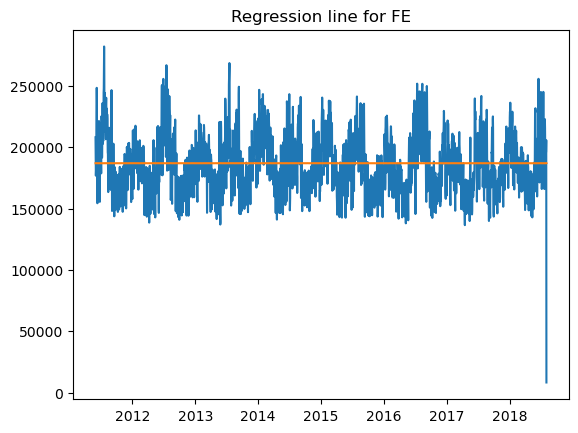

In [41]:
regression_plot_maker('FE')

In [ ]:
#singoid
# neural networks difference

In [1]:
# adding in open weather and adding max and min temp
from api_keys import open_weather

geoapi = f'https://api.openweathermap.org/data/3.0/onecall?lat=40.4406&lon={79.9959}&exclude=&appid={open_weather}'

SyntaxError: f-string: empty expression not allowed (123986461.py, line 4)